<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Можно ли использовать сверточные сети для классификации текстов? Если нет обоснуйте :D, если да то как? как решить проблему с произвольной длинной входа?

Да. Можно закодировать текст: закодировать слова или отдельные символы (символ -> вектор 0 и 1, где 1 только на месте с номером кода символа). Проблема с длиной входа решается ее ограничением (выкинуть частые бесполезные слова и совсем редкие) или рекурентными сетями.

**Вопрос 2**: Чем LSTM лучше/хуже чем обычная RNN?

RNN более забывчивая, через несколько итераций информация полностью забывается (проблема исчезающего градиента), с другой стороны LSTM не использует функцию активации внутри своих рекуррентных компонентов и хранимое значение не размывается во времени. 

**Вопрос 3**:  Выпишите производную $\frac{d c_{n+1}}{d c_{k}}$ для LSTM http://colah.github.io/posts/2015-08-Understanding-LSTMs/, объясните формулу, когда производная затухает, когда взрывается?

$\frac{d c_{n+1}}{d c_{k}} = diag(f_t)$

**Вопрос 4**: Зачем нужен TBPTT почему BPTT плох?

Он быстрее и не так сильно гасит обратные ошибки. BPTT занимает довольно много времени при большом количестве шагов.

**Вопрос 5**: Как комбинировать рекуррентные и сверточные сети, а главное зачем? Приведите несколько примеров реальных задач.

Сверточные сети хорошо анализируют изображения. Реккурентные позволяют работать с "длинными" данными. Например это можно использовать для написание лога происходящего в области видимости видеокамеры наблюдения.

**Вопрос 6**: Объясните интуицию выбора размера эмбединг слоя? почему это опасное место?

Нужно найти баланс между не слишком большой размерностью и хорошей точностью.

* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline. It can help u https://ars-ashuha.ru/slides/2016.11.11_ImageCaptioning/image_captionong.pdf 

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

In [1]:
#!wget https://www.dropbox.com/s/d50pqlm19c6f6w5/data.tar.gz?dl=0 -O data.tar.gz
#!tar -xvzf data.tar.gz

### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 2.17 s, sys: 477 ms, total: 2.65 s
Wall time: 2.49 s


In [3]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [5]:
from collections import Counter

word_counts = dict(Counter(word for a in captions for b in a for word in b))

vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [6]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [7]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[ 9003,  5799,  5401,  8257,  9774,  5271,  9281,  9707,  3233,
         2511,  7975,  2167,  4976,    -1,    -1],
       [ 9003,  3233,  2511,  9940,  2050,  7917,  2167,  7975,  6211,
         1408,  9281,  4976,    -1,    -1,    -1],
       [ 9003,  7201,  8257,  9774,  5271,  9281,  9707,  3233,  5856,
         7028,  1001,   634,  3122, 10361,  4976],
       [ 9003,  7201,  9849,  6199,   848,  9704,  7201,  9849,  3185,
         4976,    -1,    -1,    -1,    -1,    -1],
       [ 9003,  5799,  5401,  8257,  9774,  5271,  9281,  9707,  3233,
         2511,  1001,   634,  7605,  4976,    -1]], dtype=int32)

### Mah Neural Network

In [8]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 256 #pls change me if u want
LSTM_UNITS = 300 #pls change me if u want

In [9]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce 940MX (CNMeM is enabled with initial size: 75.0% of memory, cuDNN not available)


In [10]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [11]:
# network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

# embeddings for words 

l_word_embeddings = EmbeddingLayer(l_words, n_tokens, EMBED_SIZE)

In [12]:
from lasagne.nonlinearities import rectify, softmax

# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

############# TO CODE IT BY YOURSELF ##################
#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
image_features_net = DropoutLayer(l_image_features, p=0.3)
image_features_net = DenseLayer(image_features_net, LSTM_UNITS * 2)
image_features_net = DropoutLayer(image_features_net, p=0.3)
image_features_net = DenseLayer(image_features_net, LSTM_UNITS * 2)
image_features_net = DropoutLayer(image_features_net, p=0.3)
image_features_net = DenseLayer(image_features_net, LSTM_UNITS)
assert image_features_net.output_shape == (None, LSTM_UNITS)

In [13]:
decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=image_features_net,
                    mask_input=l_mask,
                    grad_clipping=50)

In [14]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer
# installing from https://github.com/yandexdataschool/AgentNet

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

ppek_net = DenseLayer(broadcast_decoder_ticks,n_tokens, nonlinearity=softmax)

#ppek_net = DropoutLayer(ppek_net, p=0.3)

#ppek_net = DenseLayer(ppek_net, n_tokens, nonlinearity=softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(ppek_net, broadcast_layer=broadcast_decoder_ticks)

print "output shape = ", predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

broadcasted decoder shape =  (None, 300)
output shape =  (None, None, 10373)


In [15]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

# write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
tloss = loss[output_mask.nonzero()].mean() # <mean over non-PAD tokens>

In [16]:
weights = lasagne.layers.get_all_params(predicted_probabilities)
updates = lasagne.updates.adam(tloss, weights, learning_rate=0.001)

In [17]:
train_step = theano.function([image_vectors, sentences], tloss, updates=updates, allow_input_downcast=True)
val_step = theano.function([image_vectors, sentences], tloss, updates=None, allow_input_downcast=True)

# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [18]:
captions = np.array(captions)

In [19]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice, captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions, max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [20]:
generate_batch(img_codes,captions, 3)

(array([[-2.17771149, -0.41586864,  1.1025219 , ...,  1.91915512,
         -1.11546075,  0.68072492],
        [-0.6015507 , -0.02649382,  1.65481973, ..., -1.42442179,
          0.15959218, -0.18993151],
        [-4.64374495,  0.27055928, -1.24535191, ..., -3.31322408,
         -1.13538623, -0.22938126]], dtype=float32),
 array([[9003, 7201, 7920,  345, 2046,  634, 7201, 9970, 7125, 4976,   -1],
        [9003, 7201, 7306, 1656, 6284, 9051, 9704, 7201,  450, 8377, 4976],
        [9003, 7201, 5872,  195, 9763, 5644, 9788, 7201, 5988, 6817, 4976]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [21]:
batch_size = 50 #adjust me
n_epochs   = 100 #adjust me
n_batches_per_epoch = 10 #adjust me
n_validation_batches = 25 #how many batches are used for validation after each epoch

In [22]:
from tqdm import tqdm

for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 0, train loss: 8.64267935753, val loss: 7.34421905518


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 1, train loss: 6.41078109741, val loss: 5.78267971039


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 2, train loss: 5.74277181625, val loss: 5.67417909622


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 3, train loss: 5.59492359161, val loss: 5.51638834


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 4, train loss: 5.44567813873, val loss: 5.40325157166


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 5, train loss: 5.34405789375, val loss: 5.29182331085


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 6, train loss: 5.2467581749, val loss: 5.27318183899


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 7, train loss: 5.19633097649, val loss: 5.13534677505


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 8, train loss: 5.148863554, val loss: 5.08304222107


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 9, train loss: 4.97140460014, val loss: 5.02963672638


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 10, train loss: 4.95012359619, val loss: 4.96919809341


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 11, train loss: 4.88911361694, val loss: 4.86822566986


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 12, train loss: 4.81788377762, val loss: 4.79789682388


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 13, train loss: 4.74098563194, val loss: 4.72536304474


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 14, train loss: 4.66132612228, val loss: 4.67500238419


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 15, train loss: 4.61096749306, val loss: 4.67086935043


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 16, train loss: 4.57037992477, val loss: 4.59067201614


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 17, train loss: 4.60451102257, val loss: 4.50680503845


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 18, train loss: 4.42988820076, val loss: 4.44834394455


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 19, train loss: 4.45123662949, val loss: 4.47466718674


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 20, train loss: 4.4155043602, val loss: 4.39634469986


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 21, train loss: 4.38274145126, val loss: 4.41004310608


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 22, train loss: 4.27998023033, val loss: 4.39545930862


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 23, train loss: 4.31325173378, val loss: 4.35340597153


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 24, train loss: 4.30648229122, val loss: 4.26014009476


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 25, train loss: 4.28407282829, val loss: 4.27597723007


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 26, train loss: 4.2157500267, val loss: 4.2425624752


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 27, train loss: 4.24965033531, val loss: 4.24957662582


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 28, train loss: 4.17109723091, val loss: 4.19440462112


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 29, train loss: 4.15021336079, val loss: 4.13225354195


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 30, train loss: 4.15153496265, val loss: 4.13103682518


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 31, train loss: 4.07307412624, val loss: 4.08595499039


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 32, train loss: 4.11337869167, val loss: 4.08099452019


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 33, train loss: 4.08106741905, val loss: 4.08070446968


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 34, train loss: 4.0646687746, val loss: 3.99905776024


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 35, train loss: 4.01824762821, val loss: 3.97996106148


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 36, train loss: 3.91190240383, val loss: 3.99536143303


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 37, train loss: 4.01112101078, val loss: 3.88388192177


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 38, train loss: 3.94103803635, val loss: 3.9910926342


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 39, train loss: 3.90120711327, val loss: 3.90669440269


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 40, train loss: 3.89731655121, val loss: 3.92517910957


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 41, train loss: 3.79885988235, val loss: 3.93345002174


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 42, train loss: 3.91015427113, val loss: 3.88206895828


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 43, train loss: 3.815833354, val loss: 3.88258155823


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 44, train loss: 3.7909999609, val loss: 3.85225922585


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 45, train loss: 3.8713886261, val loss: 3.82058261871


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 46, train loss: 3.83583502769, val loss: 3.84699768066


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 47, train loss: 3.90295748711, val loss: 3.80794939995


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 48, train loss: 3.79878757, val loss: 3.83824205399


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 49, train loss: 3.7820889473, val loss: 3.79242500305


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 50, train loss: 3.82139036655, val loss: 3.74765132904


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 51, train loss: 3.76488075256, val loss: 3.75029147148


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 52, train loss: 3.75526833534, val loss: 3.73753867149


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 53, train loss: 3.87705717087, val loss: 3.73415504456


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 54, train loss: 3.77068285942, val loss: 3.73327721596


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 55, train loss: 3.7720985651, val loss: 3.72902208328


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 56, train loss: 3.71336233616, val loss: 3.78214869499


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 57, train loss: 3.65316100121, val loss: 3.68313931465


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 58, train loss: 3.64484467506, val loss: 3.68082957268


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 59, train loss: 3.64744999409, val loss: 3.73859330177


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 60, train loss: 3.6599684, val loss: 3.69388982773


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 61, train loss: 3.67139422894, val loss: 3.61522908211


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 62, train loss: 3.61773817539, val loss: 3.64000067711


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 63, train loss: 3.72652182579, val loss: 3.61321616173


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 64, train loss: 3.62564926147, val loss: 3.62137594223


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 65, train loss: 3.59031054974, val loss: 3.56764452934


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 66, train loss: 3.63717913628, val loss: 3.5853079319


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 67, train loss: 3.6870131731, val loss: 3.64387708664


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 68, train loss: 3.56268799305, val loss: 3.57193278313


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 69, train loss: 3.60768039227, val loss: 3.56048582077


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 70, train loss: 3.46670255661, val loss: 3.53870038033


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 71, train loss: 3.61642713547, val loss: 3.60415514946


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 72, train loss: 3.5694576025, val loss: 3.51279378891


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 73, train loss: 3.51939334869, val loss: 3.53985149384


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 74, train loss: 3.47270400524, val loss: 3.54001403809


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 75, train loss: 3.56522650719, val loss: 3.47029141426


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 76, train loss: 3.52888836861, val loss: 3.55493589401


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 77, train loss: 3.496108675, val loss: 3.53419708252


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 78, train loss: 3.52168991566, val loss: 3.52117079735


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 79, train loss: 3.49030878544, val loss: 3.49707248688


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 80, train loss: 3.51273226738, val loss: 3.55961782455


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 81, train loss: 3.4543533802, val loss: 3.49578371048


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 82, train loss: 3.52713661194, val loss: 3.52352581024


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 83, train loss: 3.51014592648, val loss: 3.42315394402


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 84, train loss: 3.45495688915, val loss: 3.49636810303


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 85, train loss: 3.44156470299, val loss: 3.47890698433


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 86, train loss: 3.48456976414, val loss: 3.4663833046


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 87, train loss: 3.4532453537, val loss: 3.41522977829


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 88, train loss: 3.48235673904, val loss: 3.50288412094


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 89, train loss: 3.36484775543, val loss: 3.4300480938


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 90, train loss: 3.46442892551, val loss: 3.43467542648


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 91, train loss: 3.47239437103, val loss: 3.43103233337


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 92, train loss: 3.35324895382, val loss: 3.41136597633


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 93, train loss: 3.36644744873, val loss: 3.38575864792


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 94, train loss: 3.43685779572, val loss: 3.39516756058


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 95, train loss: 3.37346494198, val loss: 3.38609416008


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 96, train loss: 3.41732690334, val loss: 3.38207302094


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 97, train loss: 3.39278261662, val loss: 3.42703933716


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 98, train loss: 3.32540891171, val loss: 3.39273086548


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]



Epoch: 99, train loss: 3.45083913803, val loss: 3.40515814781
Finish :)


### apply trained model

In [23]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

/home/ura/tmp/AgentNet/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode=self.mode,
/home/ura/tmp/AgentNet/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode=self.mode,
/home/ura/tmp/AgentNet/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode=self.mode,


In [24]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

/usr/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


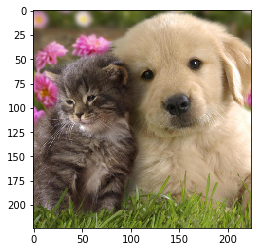

In [25]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [26]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [27]:
for i in range(10):
    print ' '.join(generate_caption(img,t=1.4)[1:-1])

a dog standing next to a fence
a cat on a table with a piece of cows
a dog sitting on a bed that is on a red fence
a dog sitting in an old wooden bed
a cat laying in the back of a small cat
a cat sitting on a bench with a yellow bear
a black cat sits on a grass of a piece of green
a cat on a blue and white cat is sitting on a field
a dog is sitting on a window
a baby cat sitting on a bed


# Bonus Part
- Use ResNet Instead of GoogLeNet
- Use W2V as embedding
- Use Attention :) 

# Pass Assignment https://goo.gl/forms/2qqVtfepn0t1aDgh1 